<a href="https://colab.research.google.com/github/lprs110/tripadvisor-sentiment-analysis/blob/master/tripadvisor_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programação para Ciência de Dados - Equipe 7

## Alunos:
* Francisco Marcelo Mendes Damasceno (fmmd.cid20@uea.edu.br)
* Lucas Pereira Reis (lpr.cid20@uea.edu.br)
* Marcos Wenneton Vieira de Araujo (mwvda.cid20@uea.edu.br)

## Visão Geral do Conjunto de Dados

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import time
from datetime import datetime, date, timedelta

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
sns.set_theme();

from google.colab import files

In [ ]:
df = pd.read_json('http://tiagodemelo.info/datasets/dataset-v2.dat', lines=True)

In [ ]:
df.sample(5)

title  ...                                       itemReviewed
51203  Sensacional.... conheço há 7anos e não muda nu...  ...  {'name': 'Bar Pé Pra Fora', 'address': {'stree...
90879                                          Romântico  ...  {'name': 'Paladino Restaurante Fazenda', 'addr...
86499                                   Vale uma visita!  ...  {'name': 'Grand Cru', 'address': {'streetAddre...
34725             Um dos melhores restaurantes da cidade  ...  {'name': 'Pitú com Pirão da Eliane', 'address'...
83490                 amei o restaurante e o atendimento  ...  {'name': 'Camarada Camarão - João Pessoa', 'ad...

[5 rows x 12 columns]

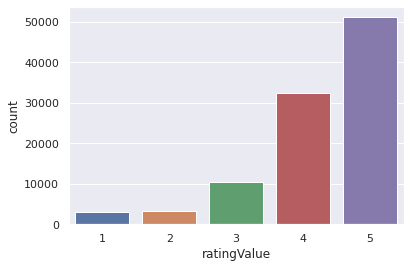

In [ ]:
sns.countplot(x="ratingValue", data=df);

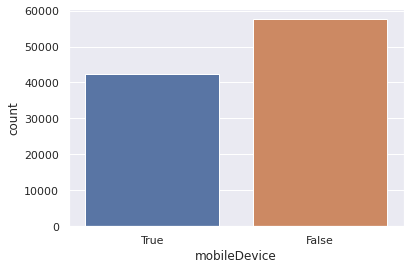

In [ ]:
sns.countplot(x="mobileDevice", data=df);

### Palavras mais utilizadas

In [ ]:
def word_cloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

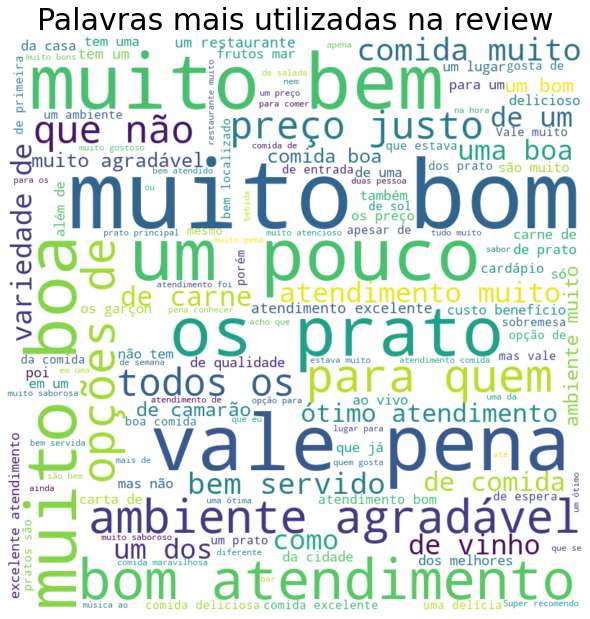

In [ ]:
word_cloud_generator(df['reviewBody'].astype(str), title="Palavras mais utilizadas na review")

## Análise de Sentimento

In [ ]:
# Instalação do pacote googletrans
!pip -q install googletrans

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 972kB 5.7MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 102kB 6.5MB/s 


In [ ]:
from googletrans import Translator
from pprint import pprint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


### Tradução do DataSet utilizando TextBlob e Googletrans

Optamos por utilizar um processo de tradução em intervalos, salvando as parciais em um arquivo `csv` no Google Drive. A razão dessa abordagem foi evitar que as traduções já realizadas fossem perdidas devido as limitações das APIs com relação a quantidade de requisições e outras eventuais interrupções por problema de conexão ou expiração do container do Colab.

Exemplo: A chamada `translate_coments(df[10000:20000],ct, method='googletrans')` vai traduzir e incrementar o dicionário temporário `ct = {'reviewId':[], 'reviewBody':[], 'reviewBody_en': []}` com a tradução dos comentários do intervalo 10000 a 20000.

Em seguida esse intervalo é salvo em arquivo da seguinte forma:

`pd.DataFrame(ct).to_csv("/content/drive/My Drive/PDC/translanted_coments_googletrans_10K_20k.csv", index=False)`

E recuperado com:

`ct = pd.read_csv('/content/drive/My Drive/PDC/translanted_coments_googletrans_10K_20k.csv').to_dict('list')`

A função `translate_text` recebe um texto e retorna a tradução através de um dos dois métodos passado como parâmetro: 'textblob' ou 'googletrans'

In [ ]:
def translate_text(text, src='auto', dest='en', method='textblob'):
  time.sleep(0.2)
  output = ''
  if method == 'textblob':
    try:
      output = TextBlob(text).translate(from_lang=src, to=dest).raw
    except NotTranslated:
      print("Não foi possível traduzir: ", text)
  elif method == 'googletrans':
    # Workaround por causa do problema - https://github.com/ssut/py-googletrans/issues/234
    translator = Translator()
    while True:
      try:
        output = translator.translate(text, src=src, dest=dest).text
        break
      except Exception as e:
        translator = Translator()
  else:
    return "'method must be either 'textblob' or 'googletrans'"
  return output

O propósito da função `translate_coments` é iterar em um DataFrame, e armazenar o resultado da tradução em um dicionário Python.

In [ ]:
def translate_coments(df, of = {}, method='textblob'):
  count = 0
  seg = 0.01 * len(df)
  for idx,row in df.iterrows():
    if count % round(seg) == 0:
      print("Processado %s%%" % (count//seg))
    count += 1
    if row.reviewId in of['reviewId']:
      # print("Review %s já existe no dataset" % row.reviewId)
      pass
    else:
      try:
        of['reviewBody_en'].append(translate_text(row['reviewBody'], method=method))
        of['reviewId'].append(row['reviewId'])
        of['reviewBody'].append(row['reviewBody'])
      except Exception as e:
        print("Erro ao processar reviewId: [%s] - reviewBody: [%s] " % (row.reviewId, row.reviewBody))
        return e

Os artefatos gerados após a tradução são dois DataSets: Um com a tradução usando método do TextBlob e outro com Googletrans

In [ ]:
# Traduções TextBlob
dft = pd.read_csv("http://underlabs.org/datasets/translated_coments_textblob.csv")
# Traduções Googletrans
dfg = pd.read_csv("http://underlabs.org/datasets/translated_coments_googletrans.csv")

### Subjetividade e Polaridade


A função `get_sentences` itera em um DataFrame de comentários traduzidos e retorna um DataFrame de sentenças 4xN com as seguintes colunas:
- 'reviewId': Id do reviewBody que originou a sentença
- 'BR': Sentença em português
- 'US': Sentença em inglês
- 'SUBJECTIVITY': Score de subjetividade
- 'POLARITY': Score de polaridade

In [ ]:
# Subjetividade e Polaridade
def get_sentences(df):
  sentences_dic = {'reviewId': [],'BR':[], 'US': [], 'SUBJECTIVITY': [], 'POLARITY': []}
  df_clean = df.replace('\n','', regex=True).replace('\.\.\.','.', regex=True)
  for idx, row in df_clean.iterrows():
    try:
      coment_blob_br = TextBlob(row['reviewBody'])
      coment_blob_us = TextBlob(row['reviewBody_en'])
    except Exception as e:
      print(row)
    for sentence_br,sentence_us in zip(coment_blob_br.sentences,coment_blob_us.sentences):
      try:
        sentences_dic['reviewId'].append(row['reviewId'])
        sentences_dic['BR'].append(sentence_br.raw)
        sentences_dic['US'].append(sentence_us.raw)
        sentences_dic['SUBJECTIVITY'].append(sentence_us.subjectivity)
        sentences_dic['POLARITY'].append(sentence_us.polarity)
      except Exception as e:
        print(row)
  return pd.DataFrame(sentences_dic)

Gerando um DataFrame de sentenças a partir de um DataSet traduzido com TextBlob

In [ ]:
dft_sentences = get_sentences(dft)

In [ ]:
dft_sentences = pd.read_csv("http://underlabs.org/datasets/dft_sentences.csv")

Gerando um DataFrame de sentenças a partir de um DataSet traduzido com Googletrans

In [ ]:
dfg_sentences = get_sentences(dfg)

In [ ]:
dfg_sentences = pd.read_csv("http://underlabs.org/datasets/dfg_sentences.csv")

Obtendo uma amostra de 200 sentenças para Anotação

In [ ]:
dfg_sentences[['BR','SUBJECTIVITY', 'POLARITY']].loc[dfg_sentences['BR'] != "!"].sample(n=200).to_csv(index=False)

Anotações


In [ ]:
df_anotacoes = pd.read_csv("http://underlabs.org/datasets/anotacoes.csv", dtype={'reviewId': 'int64'}).sort_values(by=['BR']).reset_index(drop=True)

Como o DataSet já foi completamente traduzido e subjetividade foram calculados pela função `get_sentences`, podemos aproveitar a informação para calcular a eficácia e eficiência dos métodos. Para isso utilizamos dois samples, com as mesmas sentenças anotadas, porém avaliadas pelo TextBlob/Googletrans

In [ ]:
# sample de 200 traduzido pelo textblob
dft_sample = pd.merge(dft_sentences.drop(columns=['US']), df_anotacoes.drop(columns=['SUBJECTIVITY', 'POLARITY']), how='inner', on=['reviewId','BR']).sort_values(by=['BR']).reset_index(drop=True)

In [ ]:
# sample de 200 traduzido pelo googletrans
dfg_sample = pd.merge(dfg_sentences.drop(columns=['US']), df_anotacoes.drop(columns=['SUBJECTIVITY', 'POLARITY']), how='inner', on=['reviewId','BR']).sort_values(by=['BR']).reset_index(drop=True)

A classe SentimentAnalyzesMetrics carrega dois data frames, um produzido pelo método, e outro que serve como gabarito (ground-truth). O Construtor dessa classe possui os seguintes parâmetros:


- `df`: DataFrame com as respostas dadas pelo método
- `dfgt`: DataFrame ground-truth (gabarito)
-`sub_limit`: valor de corte para avaliação da subjetividade
- `pol_limit`: valor de corte para avaliação da polaridade

As métricas são obtidas em formato de dicionário Python, através dos métodos `subjectivity` e `polarity`.

O cálculo das métricas são realizados com base nas fórmulas abaixo:

$Accuracy = \frac{\sum TruePositive + \sum TrueNegative)}{\sum TestDataSize}$

$Precision = \frac{\sum TruePositive}{\sum TruePositive) + \sum FalsePositive}$

$Recall = \frac{\sum TruePositive }{\sum TruePositve) + \sum FalseNegative}$

$F-Measure = \frac{2 \times Precision \times Recall}{Precision + Recall}$


In [ ]:
class SentimentAnalyzesMetrics:

  def __init__(self, df, dfgt, sub_limit=0.5, pol_limit=0):
    self.df = df
    self.dfgt = dfgt
    self.dssize = len(df)
    self.sub = {}
    self.pol = {}
    self.sub_limit = sub_limit
    self.pol_limit = pol_limit
    self._load_data()

  def _load_data(self):
    self.sub['y_true'] = self.dfgt['SUBJECTIVITY'].astype(int)
    self.sub['y_pred'] = self.df['SUBJECTIVITY'].apply(lambda x:(0,1)[x >= self.sub_limit])
    self.pol['y_true'] = self.dfgt['POLARITY'].astype(int)
    self.pol['y_pred'] = self.df['POLARITY'].apply(self._format_predict_polarity)

  def _format_predict_polarity(self, num):
    if num > self.pol_limit:
      return 1
    elif num < self.pol_limit:
      return -1
    else:
      return 0

  def subjectivity(self, metric='report'):
    if metric == 'precision':
      return precision_score(self.sub['y_true'], self.sub['y_pred'])
    elif metric == 'recall':
      return recall_score(self.sub['y_true'], self.sub['y_pred'])
    elif metric == 'f1':
      return f1_score(self.sub['y_true'], self.sub['y_pred'])
    elif metric == 'report':
      print(classification_report(self.sub['y_true'], self.sub['y_pred']))
    else:
      return "metric parameter invalid: use 'precision', 'recall', 'f1' or 'report'"

  def polarity(self, metric='report', average=None):
    if metric == 'precision':
      return precision_score(self.pol['y_true'], self.pol['y_pred'], average=average)
    elif metric == 'recall':
      return recall_score(self.pol['y_true'], self.pol['y_pred'], average=average)
    elif metric == 'f1':
      return f1_score(self.pol['y_true'], self.pol['y_pred'], average=average)
    elif metric == 'report':
      print(classification_report(self.pol['y_true'], self.pol['y_pred']))
    else:
      return "metric parameter invalid: use 'precision', 'recall', 'f1' or 'report'"


  def cm_subjectivity(self):
    cm = confusion_matrix(self.sub['y_true'], self.sub['y_pred'])
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percents = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    annot = [f'{l1}\n{l2}' for l1, l2 in zip (group_counts, group_percents)]
    annot = np.asarray(annot).reshape(2,2)    
    dfcm = pd.DataFrame(cm,
                        index=['True: 0', 'True: 1'],
                        columns=['Pred: 0', 'Pred: 1'])
    sns.heatmap(dfcm,fmt='', annot=annot, cmap='Blues', cbar=False)

  def cm_polarity(self):
    cm = confusion_matrix(self.pol['y_true'], self.pol['y_pred'])
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percents = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    annot = [f'{l1}\n{l2}' for l1, l2 in zip (group_counts, group_percents)]
    annot = np.asarray(annot).reshape(3,3)    
    dfcm = pd.DataFrame(cm,
                        index=['True: -1','True: 0', 'True: 1'],
                        columns=['Pred: -1','Pred: 0', 'Pred: 1'])
    sns.heatmap(dfcm,fmt='', annot=annot, cmap='Blues', cbar=False)    

#### Avaliando o método: TextBlob

In [ ]:
samtb = SentimentAnalyzesMetrics(dft_sample, df_anotacoes)

Subjetividade

In [ ]:
sub_dic = {
    'Precision': samtb.subjectivity('precision'),
    'Recall': samtb.subjectivity('recall'),
    'f1_score': samtb.subjectivity('f1'),}
pprint(sub_dic)

{'Precision': 0.8629032258064516,
 'Recall': 0.7278911564625851,
 'f1_score': 0.7896678966789669}


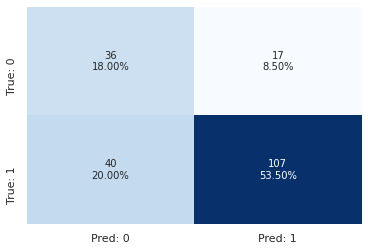

In [ ]:
# Confusion Matrix: Subjectivity
samtb.cm_subjectivity()

Polaridade

In [ ]:
pol_dic = {
    'Precision': samtb.polarity('precision'),
    'Recall': samtb.polarity('recall'),
    'f1_score': samtb.polarity('f1'),}
pprint(pol_dic)

{'Precision': array([0.375     , 0.65116279, 0.81560284]),
 'Recall': array([0.35294118, 0.5       , 0.90551181]),
 'f1_score': array([0.36363636, 0.56565657, 0.85820896])}


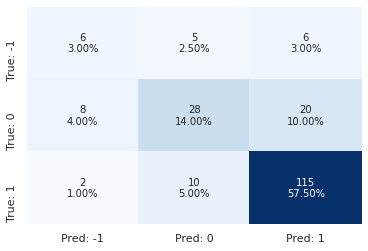

In [ ]:
# Confusion Matrix: Polarity
samtb.cm_polarity()

#### Avaliando o método: Googletrans

In [ ]:
samgt = SentimentAnalyzesMetrics(dfg_sample, df_anotacoes)

Subjetividade

In [ ]:
sub_dic = {
    'Precision': samgt.subjectivity('precision'),
    'Recall': samgt.subjectivity('recall'),
    'f1_score': samgt.subjectivity('f1'),}
pprint(sub_dic)

{'Precision': 0.8629032258064516,
 'Recall': 0.7278911564625851,
 'f1_score': 0.7896678966789669}


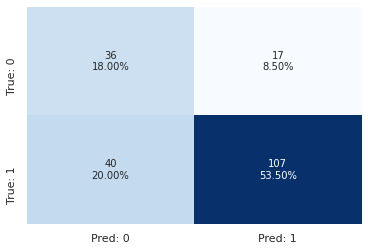

In [ ]:
# Confusion Matrix: Subjectivity
samgt.cm_subjectivity()

Polaridade

In [ ]:
pol_dic = {
    'Precision': samgt.polarity('precision'),
    'Recall': samgt.polarity('recall'),
    'f1_score': samgt.polarity('f1'),}
pprint(pol_dic)

{'Precision': array([0.375     , 0.64285714, 0.80985915]),
 'Recall': array([0.35294118, 0.48214286, 0.90551181]),
 'f1_score': array([0.36363636, 0.55102041, 0.85501859])}


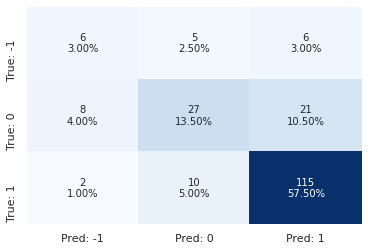

In [ ]:
# Confusion Matrix: Polarity
samgt.cm_polarity()

## Visão Temporal

In [ ]:
dfTemporal = df.copy()

# dfTemporal.drop(dfTemporal[dfTemporal.visitDate == 'None'].index, inplace=True)

In [ ]:
dfTemporal.head()

title  ...                                       itemReviewed
0                               Jantar   ...  {'name': 'Imperador dos Camarões', 'address': ...
1                  Uma boa experiência.  ...  {'name': 'Guacamole Natal', 'address': {'stree...
2                    Otimo self service  ...  {'name': 'Chica Pitanga', 'address': {'streetA...
3  O sorvete mais tradicional do estado  ...  {'name': 'Sorvetes Vi Sabor', 'address': {'str...
4                     Melhor hamburger!  ...  {'name': 'Z Deli Sandwich Shop', 'address': {'...

[5 rows x 12 columns]

In [ ]:
dayOfWeek = {0:'segunda', 1:'terca', 2:'quarta', 3:'quinta', 4:'sexta', 5:'sabado', 6:'domingo'}
dfTemporal['publicationDate'] = pd.to_datetime(dfTemporal['publicationDate'], format = '%d/%m/%Y')

# Criando novas colunas para analisar

dfTemporal['publicationDayOfWeek'] = dfTemporal.publicationDate.dt.dayofweek.map(dayOfWeek)
dfTemporal['publicationDay'] = dfTemporal.publicationDate.dt.day
dfTemporal['publicationMonth'] = dfTemporal.publicationDate.dt.month
dfTemporal['publicationYear'] = dfTemporal.publicationDate.dt.year

In [ ]:
dfTemporal.head()

title  ...  publicationYear
0                               Jantar   ...             2019
1                  Uma boa experiência.  ...             2014
2                    Otimo self service  ...             2019
3  O sorvete mais tradicional do estado  ...             2016
4                     Melhor hamburger!  ...             2015

[5 rows x 16 columns]

### Visão Temporal da Data de Publicação

In [ ]:
def count_plot(data, x, order=[], title='', figsize=(12, 7)):plt.figure(figsize=figsize)
  plt.title(title)
  if order:
    sns.countplot(x=x, data=data, order=order)
  else:
    sns.countplot(x=x, data=data)
  plt.show()
  plt.figure(figsize=figsize)
  plt.title(title)
  if order:
    sns.countplot(x=x, data=data, order=order)
  else:
    sns.countplot(x=x, data=data)
  plt.show()

def bar_plot(data, x, y, title='', figsize=(12, 7)):
  plt.figure(figsize=figsize)
  plt.title(title)
  sns.barplot(x=x, y=y, data=data)
  plt.show()

def scatter_plot(data, x, y, title='', figsize=(12, 7)):
  plt.figure(figsize=figsize)
  plt.title(title)
  sns.scatterplot(data=data, x=x, y=y)
  plt.show()

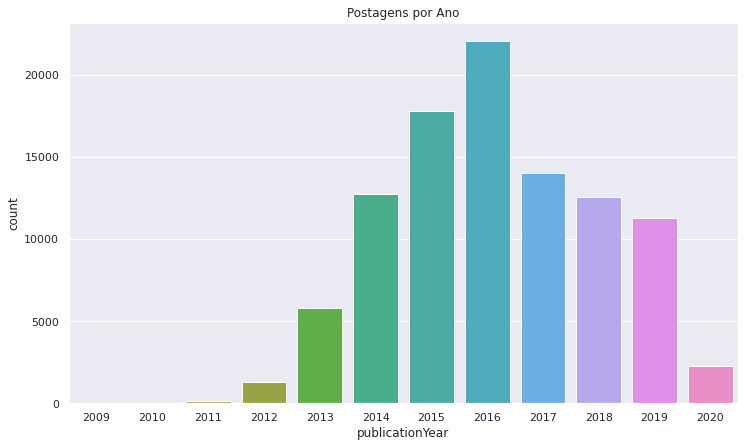

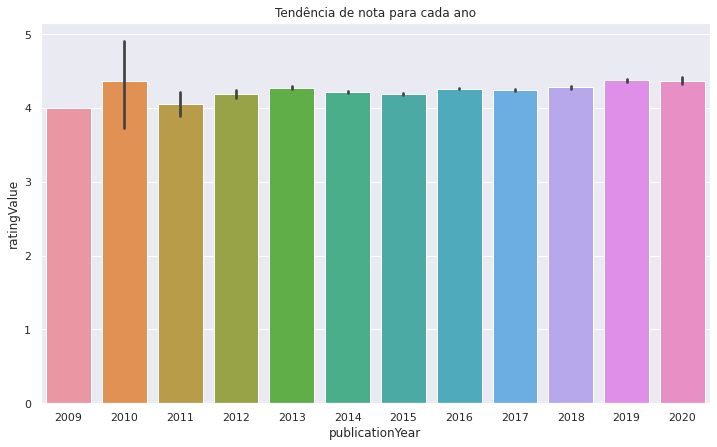

In [ ]:
years = list(dfTemporal.publicationYear.unique())
years.sort()

count_plot(dfTemporal, "publicationYear", years, 'Postagens por Ano')

bar_plot(dfTemporal, "publicationYear", "ratingValue", "Tendência de nota para cada ano")

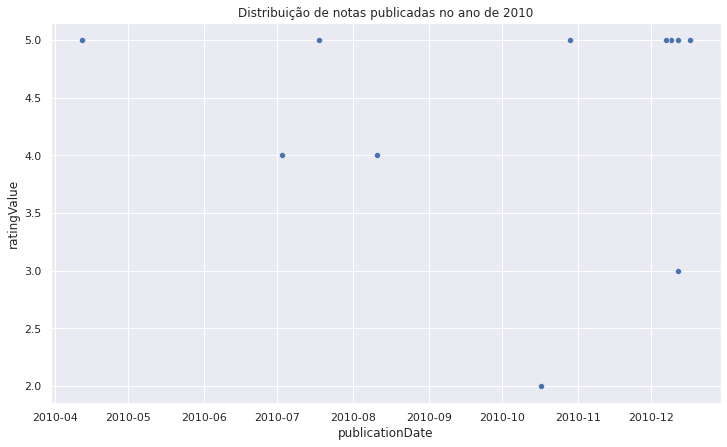

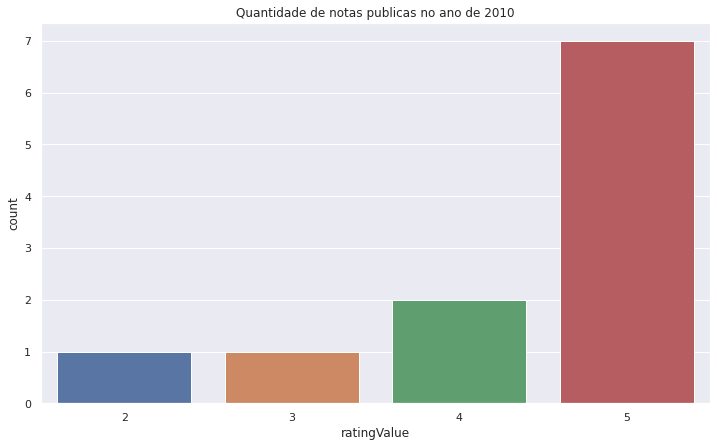

In [ ]:
# O ano de 2010 apresentou uma variação grande no gráfico anterior, portanto é interessante analisar a distribuição de notas para ele
df2010 = dfTemporal.copy()
df2010 = df2010[df2010.publicationDate.dt.year == 2010]

scatter_plot(df2010, "publicationDate", "ratingValue", "Distribuição de notas publicadas no ano de 2010")
count_plot(df2010, "ratingValue", title="Quantidade de notas publicas no ano de 2010")

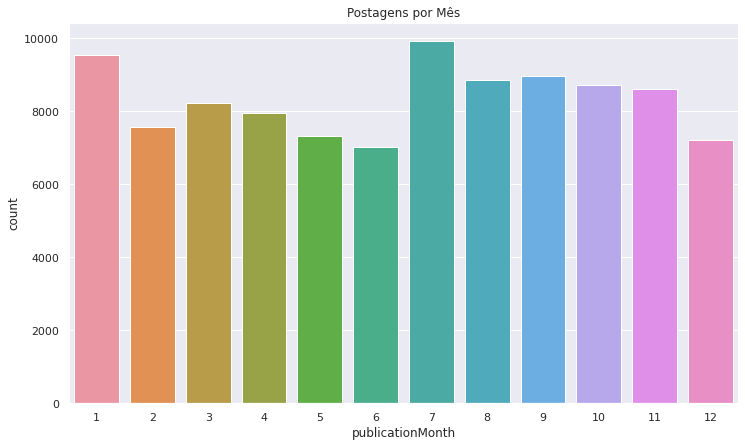

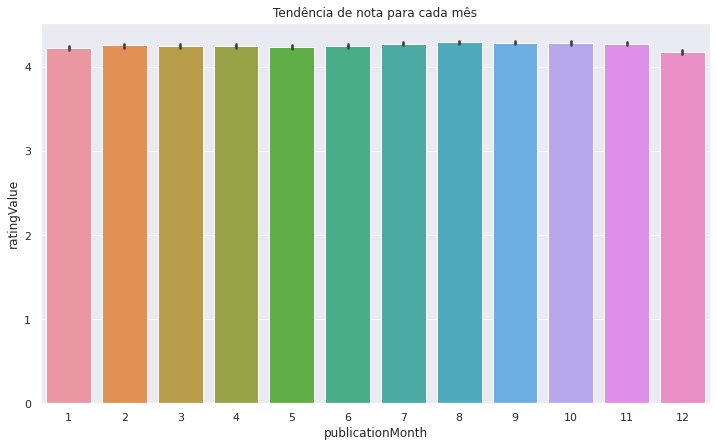

In [ ]:
months = list(dfTemporal.publicationMonth.unique())
months.sort()

count_plot(dfTemporal, "publicationMonth", months, 'Postagens por Mês')

bar_plot(dfTemporal, "publicationMonth", "ratingValue", "Tendência de nota para cada mês")

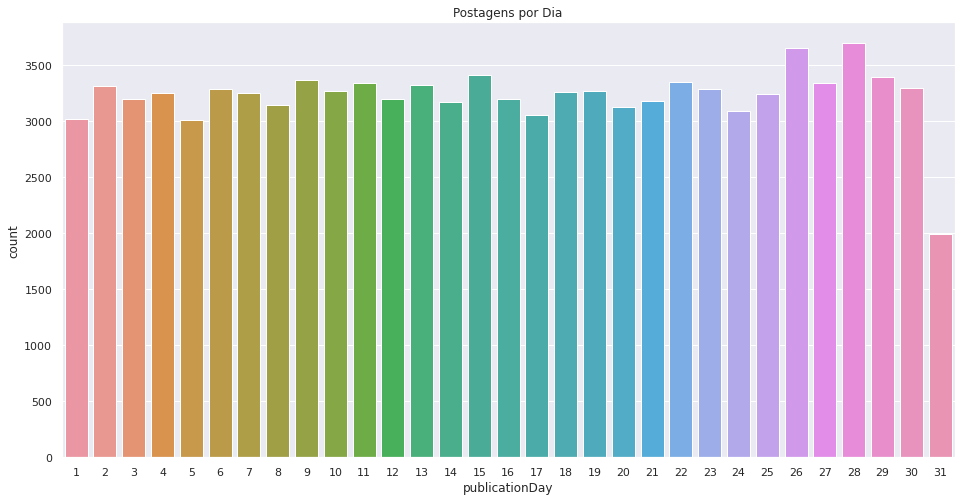

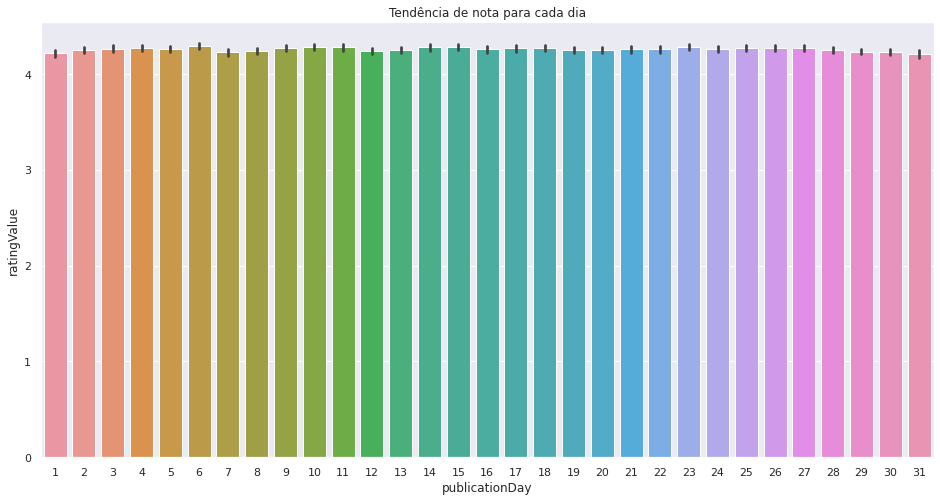

In [ ]:
days = list(dfTemporal.publicationDay.unique())
days.sort()

count_plot(dfTemporal, "publicationDay", days, 'Postagens por Dia', (16, 8))

bar_plot(dfTemporal, "publicationDay", "ratingValue", "Tendência de nota para cada dia", (16, 8))

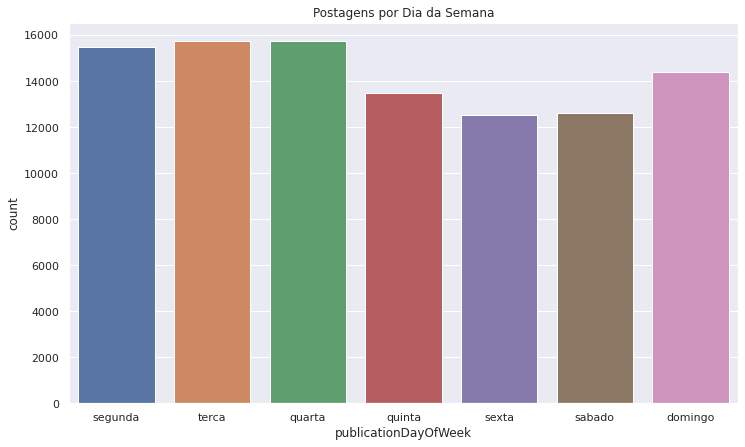

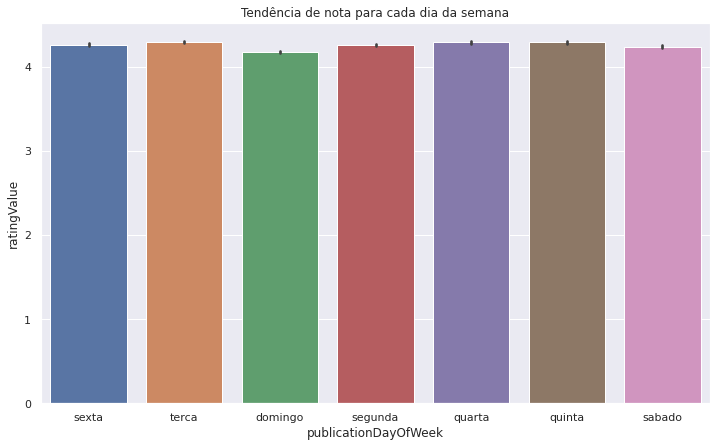

In [ ]:
count_plot(dfTemporal, "publicationDayOfWeek", ['segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 'domingo'], 'Postagens por Dia da Semana')

bar_plot(dfTemporal, "publicationDayOfWeek", "ratingValue", "Tendência de nota para cada dia da semana")

### Visão Temporal da Data de Visita

In [ ]:
dfTemporalVisited = dfTemporal.copy()

# Removendo linhas que possuem 'None' como data de visita, pois não será interessante analisá-los

dfTemporalVisited.drop(dfTemporalVisited[dfTemporalVisited.visitDate == 'None'].index, inplace=True)

print(f'Quantidade de linhas que possuem None como Data de Visita: {len(dfTemporal) - len(dfTemporalVisited)}')

Quantidade de linhas que possuem None como Data de Visita: 4330


In [ ]:
dfTemporalVisited['visitDate'] = pd.to_datetime(dfTemporalVisited['visitDate'], format = '%m/%Y')

# Criando novas colunas para analisar

dfTemporalVisited['visitMonth'] = dfTemporalVisited.visitDate.dt.month
dfTemporalVisited['visitYear'] = dfTemporalVisited.visitDate.dt.year

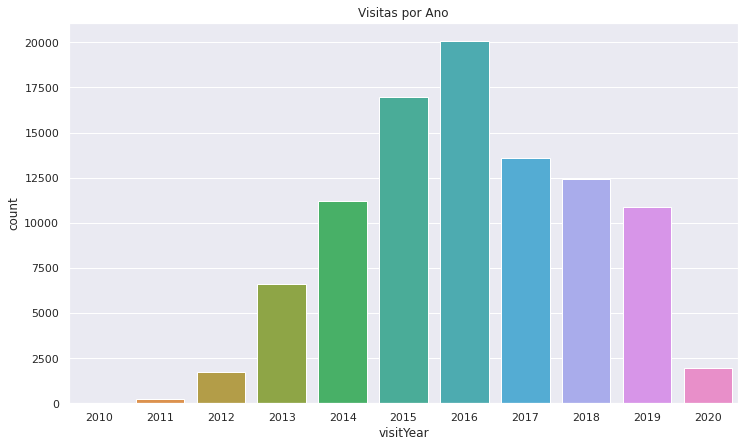

In [ ]:
years = list(dfTemporalVisited.visitYear.unique())
years.sort()

count_plot(dfTemporalVisited, "visitYear", years, 'Visitas por Ano')

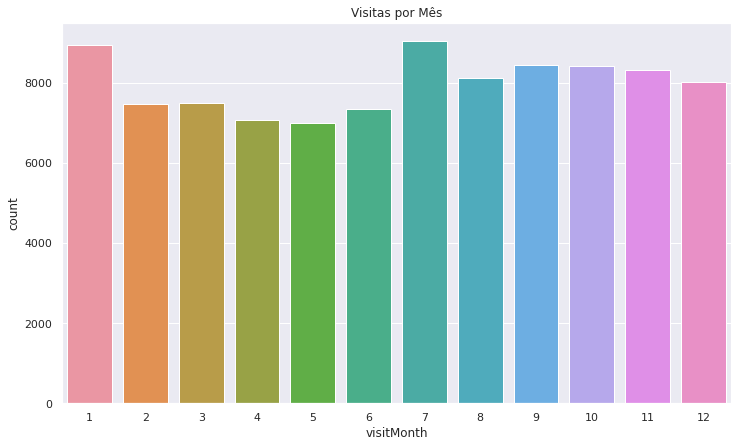

In [ ]:
months = list(dfTemporalVisited.visitMonth.unique())
months.sort()

count_plot(dfTemporalVisited, "visitMonth", months, 'Visitas por Mês')

### Visão Temporal de um Restaurante Específico (CocoBambu)

In [ ]:
# É interessante também analisar um restaurante específico
# Foi escolhido o restaurante com o maior número de reviews
restaurantId = dfTemporal.restaurantId.value_counts().index[0]

dfTemporalRestaurant = dfTemporal.copy()
dfTemporalRestaurant = dfTemporalRestaurant[dfTemporalRestaurant.restaurantId == restaurantId]

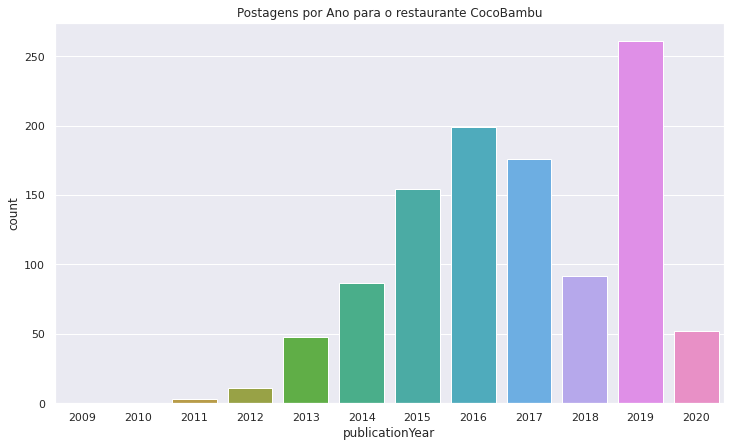

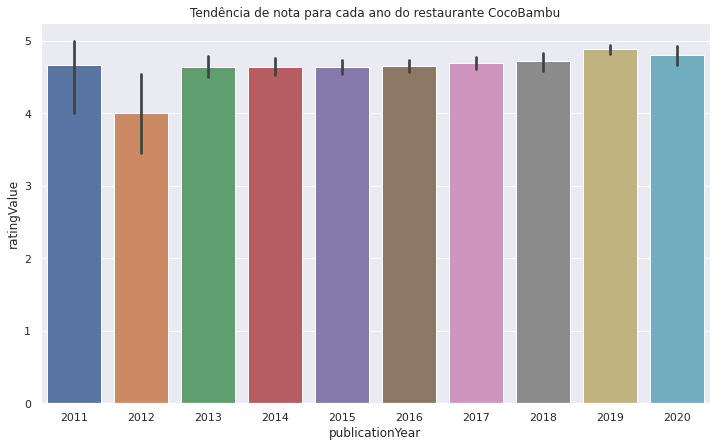

In [ ]:
years = list(dfTemporal.publicationYear.unique())
years.sort()

count_plot(dfTemporalRestaurant, 'publicationYear', years, 'Postagens por Ano para o restaurante CocoBambu')

bar_plot(dfTemporalRestaurant, "publicationYear", "ratingValue", "Tendência de nota para cada ano do restaurante CocoBambu")

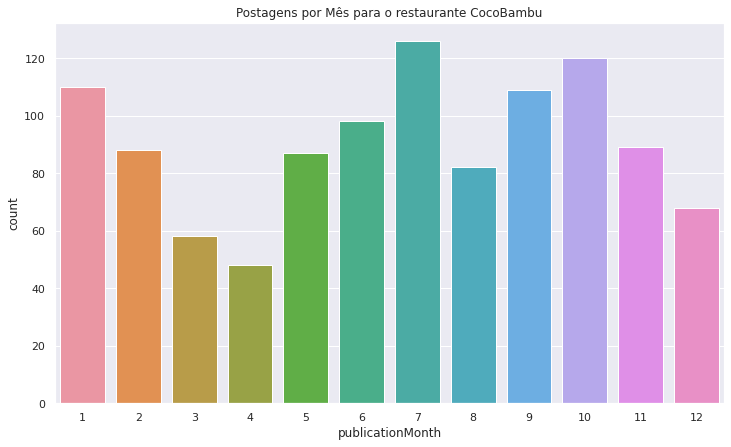

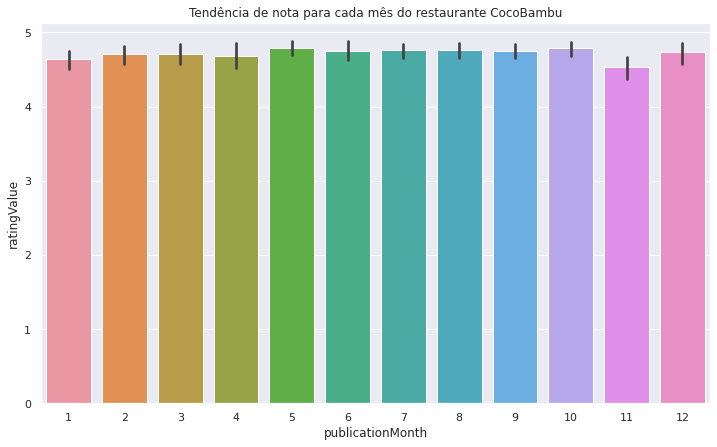

In [ ]:
months = list(dfTemporal.publicationMonth.unique())
months.sort()

count_plot(dfTemporalRestaurant, "publicationMonth", months, 'Postagens por Mês para o restaurante CocoBambu')

bar_plot(dfTemporalRestaurant, "publicationMonth", "ratingValue", "Tendência de nota para cada mês do restaurante CocoBambu")

## Visão Geográfica

In [ ]:
'''
Objetivos:
- Diminuir quantidades de requisições para a API de latitude e longitude
- Como fazer isso?
  - Remover nomes repetidos para evitar fazer dois requisições para o mesmo lugar
    - Ex.: São Paulo, sao paulo, SÃO PAULO
  - Pegar latitude e longitude de um dataset já pronto
    - Só será feito a requisição caso não tenha no dataset
'''

'\nObjetivos:\n- Diminuir quantidades de requisições para a API de latitude e longitude\n- Como fazer isso?\n  - Remover nomes repetidos para evitar fazer dois requisições para o mesmo lugar\n    - Ex.: São Paulo, sao paulo, SÃO PAULO\n  - Pegar latitude e longitude de um dataset já pronto\n    - Só será feito a requisição caso não tenha no dataset\n'

In [ ]:
# https://simplemaps.com/data/world-cities
files.upload()

Saving worldcities.csv to worldcities.csv


{'worldcities.csv': b'"city","city_ascii","lat","lng","country","iso2","iso3","admin_name","capital","population","id"\r\n"Tokyo","Tokyo","35.6897","139.6922","Japan","JP","JPN","T\xc5\x8dky\xc5\x8d","primary","37977000","1392685764"\r\n"Jakarta","Jakarta","-6.2146","106.8451","Indonesia","ID","IDN","Jakarta","primary","34540000","1360771077"\r\n"Delhi","Delhi","28.6600","77.2300","India","IN","IND","Delhi","admin","29617000","1356872604"\r\n"Mumbai","Mumbai","18.9667","72.8333","India","IN","IND","Mah\xc4\x81r\xc4\x81shtra","admin","23355000","1356226629"\r\n"Manila","Manila","14.5958","120.9772","Philippines","PH","PHL","Manila","primary","23088000","1608618140"\r\n"Shanghai","Shanghai","31.1667","121.4667","China","CN","CHN","Shanghai","admin","22120000","1156073548"\r\n"S\xc3\xa3o Paulo","Sao Paulo","-23.5504","-46.6339","Brazil","BR","BRA","S\xc3\xa3o Paulo","admin","22046000","1076532519"\r\n"Seoul","Seoul","37.5833","127.0000","Korea, South","KR","KOR","Seoul","primary","2179400

In [ ]:
dfWorldCities = pd.read_csv('worldcities.csv')
dfWorldCities = dfWorldCities[['city', 'city_ascii', 'country', 'lat', 'lng']]

In [ ]:
dfWorldCities.head()

city city_ascii      country      lat       lng
0    Tokyo      Tokyo        Japan  35.6897  139.6922
1  Jakarta    Jakarta    Indonesia  -6.2146  106.8451
2    Delhi      Delhi        India  28.6600   77.2300
3   Mumbai     Mumbai        India  18.9667   72.8333
4   Manila     Manila  Philippines  14.5958  120.9772

In [ ]:
import geopandas
from geopy.geocoders import Nominatim
from collections import Counter, defaultdict
import copy
from difflib import SequenceMatcher
import unidecode
from random import randint

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 8.8MB/s 
     |████████████████████████████████| 14.8MB 343kB/s 
     |████████████████████████████████| 6.5MB 43.6MB/s 


In [ ]:
!pip install unidecode
!pip install Unidecode

     |████████████████████████████████| 245kB 8.6MB/s 


In [ ]:
print(locator.geocode('Santa Bárbara d&amp;#39;Oeste, Brasil') is not None)

False


In [ ]:
dfLocation = df.copy()

# removendo linhas de lugares inexistentes
dfLocation.drop(dfLocation[dfLocation.userLocation == 'None'].index, inplace = True)
dfLocation.drop(dfLocation[dfLocation.userLocation == 'São'].index, inplace = True)
dfLocation.drop(dfLocation[dfLocation.userLocation == 'São'].index, inplace = True)

# Alguns lugares são tão específicos que fica difícil analisá-los de forma geral, portanto ocorre a necessidade de alterá-los manualmente
dfLocation.userLocation = dfLocation.userLocation.replace(['SSA', 'Ssa'], 'Salvador, Bahia')
dfLocation.userLocation = dfLocation.userLocation.replace(['Ji-Paraná'], 'Ji-Paraná, RO')
dfLocation.userLocation = dfLocation.userLocation.replace(['Bragança Paulista', 'Braganca Paulista, Brazil'], 'Bragança Paulista, SP')
dfLocation.userLocation = dfLocation.userLocation.replace(['POa', 'Poa'], 'Porto Alegre, RS')
dfLocation.userLocation = dfLocation.userLocation.replace(['Poá, SP', 'Poá'], 'Poá, SP')
dfLocation.userLocation = dfLocation.userLocation.replace(['BH', 'bh', 'BH, Brasil'], 'Belo Horizonte, MG')
dfLocation.userLocation = dfLocation.userLocation.replace(['Bauru, null, Democratic Republic of the Congo'], 'Bauru, Democratic Republic of the Congo')
dfLocation.userLocation = dfLocation.userLocation.replace(['SP, sp', 'Sp'], 'São Paulo, SP')

In [ ]:
dfLocation[dfLocation.userLocation == 'Santa Bárbara d&amp;#39;Oeste, Brasil']

title  ...                                       itemReviewed
1990  recomendo  ...  {'name': 'Imperador dos Camarões', 'address': ...

[1 rows x 12 columns]

In [ ]:
 def check_city(city_dict, new_city):
  for city in city_counter:

    compare_new_city = unidecode.unidecode(new_city.lower())
    compare_city = unidecode.unidecode(city.lower())

    if ',' in compare_city:
      compare_city = compare_city.split(',')[0]
    
    if ',' in compare_new_city:
      compare_new_city = compare_new_city.split(',')[0]

    if compare_new_city in compare_city:
      if SequenceMatcher(None, compare_new_city, compare_city).ratio() >= 0.8:
        return city
    
  return ""

In [ ]:
# Algumas cidades podem prejudicar a verificação  de cidades repetidas
cities_to_remove = ['brasil', 'brazil', 'ji-paraná, ro', 'bauru, democratic republic of the congo']
list_unique_cities = dfLocation.userLocation.unique()

list_unique_cities = [city for city in list_unique_cities if city.lower() not in cities_to_remove]

In [ ]:
city_counter = {}

for city in list_unique_cities:
  city_found = check_city(city_counter, city)

  if city_found != "":
    city_counter[city_found].append(city)
  else:
    city_counter[city] = []


repeated_cities = { city:repeated_cities for city, repeated_cities in city_counter.items() if len(repeated_cities) > 1}
# isolated_cities = { city:repeated_cities for city, repeated_cities in city_counter.items() if len(repeated_cities) == 0}

print(repeated_cities)
# print(isolated_cities)

{'São Carlos, SP': ['São Carlos, São Paulo, Brazil', 'São Carlos, SC', 'São Carlos'], 'Manaus, AM': ['Manaus', 'MANAUS', 'manaus', 'Manaus, Amazonas, Brazil', 'Manaus, Brasil', 'Manaus, Brazil', 'Manaus, Brasil, América do Sul'], 'Goiânia, GO': ['Goiânia, Goias, Brazil', 'Goiânia', 'Goiania, Brazil', 'Goiania, Go', 'Goiania', 'goiania', 'Goiânia, Brasil', 'Goiânia, Go', 'Goiania, GO', 'Goiânia, Goiás'], 'Aracaju, SE': ['ARACAJU', 'Aracaju', 'Aracaju, Brasil', 'aracaju', 'Aracaju, Brazil', 'Aracaju, Sergipe, Brazil'], 'Rio de Janeiro, RJ': ['Rio de Janeiro', 'rio de janeiro', 'Rio de Janeiro, Rio de Janeiro, Brazil', 'Rio de Janeiro, Brazil', 'Rio de Janeiro, Brasil', 'Rio De Janeiro', 'Rio de janeiro', 'RIO DE JANEIRO', 'RIO DE JANEIRO, Brazil', 'Rio De Janeiro, Brazil', 'Rio De Janeiro, Brasil', 'rio de janeiro, Brasil', 'Rio de Jan', 'rio de Janeiro', 'Rio De Janeiro, Rj', 'Río de Janeiro, RJ', 'Rio De Janeiro, Capital', 'rio de janeiro, rio de janeiro'], 'Brasília, DF': ['Brasília, 

In [ ]:
for city, change_cities_list in repeated_cities.items():
  dfLocation.userLocation = dfLocation.userLocation.replace(change_cities_list, city)

In [ ]:
dfLocation.head()

title  ...                                       itemReviewed
0                               Jantar   ...  {'name': 'Imperador dos Camarões', 'address': ...
1                  Uma boa experiência.  ...  {'name': 'Guacamole Natal', 'address': {'stree...
2                    Otimo self service  ...  {'name': 'Chica Pitanga', 'address': {'streetA...
3  O sorvete mais tradicional do estado  ...  {'name': 'Sorvetes Vi Sabor', 'address': {'str...
4                     Melhor hamburger!  ...  {'name': 'Z Deli Sandwich Shop', 'address': {'...

[5 rows x 12 columns]

In [ ]:
def geocode(city, recursion=0, timeout=100, sleep_sec=2):
  try:
    return locator.geocode(city, timeout)
  except Exception as e:
    if recursion > 10:      # max recursions
      print("Error in request for city: ", city)
      raise e
    time.sleep(randint(1 * 100, sleep_sec * 100) / 100) # random sleep
    # time.sleep(1 * (recursion+1))
    # try again
    return geocode(city, recursion=recursion + 1)

In [ ]:
def findCity(listOfCities, city):
  try:
    index = listOfCities.index(city)
    return index
  except ValueError:
    return -1

In [ ]:
location = {'latitude': [], 'longitude': [], 'city': [], 'lastIndex': -1}

In [ ]:
user_agent = 'TRIPADVISOR_{}'.format(randint(10000,99999))
locator = Nominatim(user_agent=user_agent)

for index, row in dfLocation.iterrows():

  if index > location['lastIndex']:
    #print("Current Index: ", index)
    city = row.userLocation

    cityIndex = findCity(location['city'], city)

    if cityIndex != -1:
      print("Repated city! ", city)
      latitude = location['latitude'][cityIndex]
      longitude = location['longitude'][cityIndex]

      location['latitude'].append(latitude)
      location['longitude'].append(longitude)
    else:
      print("Processing city: ", city)
      data = geocode(city)

      location['city'].append(city)
      
      if data is not None:
        location['latitude'].append(data.latitude)
        location['longitude'].append(data.longitude)
      else:
        location['latitude'].append(np.nan)
        location['longitude'].append(np.nan)
      
      time.sleep(2)
    location['lastIndex'] = index

A saída de streaming foi truncada nas últimas 5000 linhas.
Repated city!  Vila Velha, ES
Repated city!  Caruaru, PE
Repated city!  Porto Alegre, Brasil
Repated city!  Rio de Janeiro, RJ
Repated city!  Brasília, DF
Repated city!  Brasília, DF
Repated city!  Jacareí, SP
Repated city!  Rio de Janeiro, RJ
Repated city!  Fortaleza, Brasil
Repated city!  São Paulo, SP
Repated city!  Salvador, BA
Repated city!  Curitiba, PR
Repated city!  São Paulo, SP
Processing city:  Barra de Ibiraquera, SC
Repated city!  Porto Alegre, Brasil
Repated city!  Curitiba, PR
Repated city!  Recife, PE
Repated city!  São Paulo, SP
Processing city:  Haia, Países Baixos
Repated city!  Recife, PE
Repated city!  Aracaju, SE
Repated city!  Porto Alegre, Brasil
Repated city!  Teresina, PI
Repated city!  Curitiba, PR
Repated city!  São Paulo, SP
Repated city!  Teresina, PI
Repated city!  São Paulo, SP
Repated city!  São Paulo, SP
Repated city!  Natal, Rio Grande do Norte, Brazil
Repated city!  São Paulo, SP
Repated city

KeyboardInterrupt: ignored

In [ ]:
locationBackup = location.copy()

In [ ]:
with open('location-backup.json', 'w') as fp:
  json.dump(location, fp)

In [ ]:
with open('location-backup.json') as json_file:
  newLocation = json.load(json_file)